### Carregando bibliotecas necessárias

In [211]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.patches as mpatches

import os

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

### Etapa de Load

#### Lendo os arquivos de csv

In [212]:
financial_transactions_path = r'..\data copy\Transacoes_2.csv'
cotumers_path = r'..\data copy\Clientes_2.csv'

df_financial_transactions = pd.read_csv(financial_transactions_path, delimiter=';')
df_clientes = pd.read_csv(cotumers_path, delimiter=';', encoding='latin1')

#### Entendendo os dados

In [213]:
df_financial_transactions.dtypes

DATA                object
VALOR_TRANSACAO     object
PRODUTO             object
NUM_LOJA           float64
ID_PESSOA            int64
dtype: object

In [214]:
df_clientes.dtypes

ID_PESSOA                int64
NIVEL_CLIENTE           object
DATA_ALTERACAO_NIVEL    object
CIDADE                  object
dtype: object

In [215]:
valores_nulos_financial = df_financial_transactions.isnull().sum()

print("Valores nulos por coluna:")
print(valores_nulos_financial)

Valores nulos por coluna:
DATA               0
VALOR_TRANSACAO    0
PRODUTO            0
NUM_LOJA           0
ID_PESSOA          0
dtype: int64


In [216]:
valores_nulos_clientes = df_clientes.isnull().sum()

print("Valores nulos por coluna:")
print(valores_nulos_clientes)

Valores nulos por coluna:
ID_PESSOA               0
NIVEL_CLIENTE           0
DATA_ALTERACAO_NIVEL    0
CIDADE                  0
dtype: int64


### Etapa de Transformação

#### Funções usadas na transformação

In [217]:
def normalize_values(value):
    if value < 1:
        return round(value, 2)
    elif value >= 1:
        return round(value, 2)
    return value

In [218]:
def truncate_decimal_column(df, column_name):
    df[column_name] = df[column_name].astype(int)
    return df

In [219]:
def drop_column(df, column_name):
    if column_name in df.columns:
        df = df.drop(columns=[column_name])
    else:
        print(f"Coluna '{column_name}' não encontrada.")
    return df

In [220]:
def rename_column(df, old_name, new_name):
    if old_name in df.columns:
        df = df.rename(columns={old_name: new_name})
    else:
        print(f"Coluna '{old_name}' não encontrada.")
    return df

In [221]:
def standardize_column(df, column_name):
    if column_name in df.columns:
        df[column_name] = (
            df[column_name]
            .str.upper()
            .str.replace(r'[^A-Z_\s]', '', regex=True)
        )
    else:
        print(f"Coluna '{column_name}' não encontrada.")
    return df

In [222]:
def filter_zscore(df, column, threshold=3):
    y_zscores = zscore(df[column])
    mask_zscore = (abs(y_zscores) < threshold)
    df_filtered = df[mask_zscore]
    return df_filtered

In [223]:
def get_removed_records(df_original, df_filtered):
    df_removed = df_original[~df_original.index.isin(df_filtered.index)]
    return df_removed

In [224]:
def remove_negative_values(df, column_name):

    if column_name in df.columns:
        original_count = len(df)
        df = df[df[column_name] >= 0]
        removed_count = original_count - len(df)
    else:
        print(f"Coluna '{column_name}' não encontrada no DataFrame.")
    return df

In [225]:
def filtrar_intervalo_datas(df, coluna_data, data_inicio='2022-06-01', data_fim='2023-12-31'):
    df[coluna_data] = pd.to_datetime(df[coluna_data], format='%d/%m/%Y', errors='coerce')

    data_inicio = pd.to_datetime(data_inicio)
    data_fim = pd.to_datetime(data_fim)

    df_filtrado = df[
        (df[coluna_data] >= data_inicio) & 
        (df[coluna_data] <= data_fim)
    ].copy()

    return df_filtrado

In [226]:
def listar_usuarios_por_cluster_df(df, coluna_usuario, coluna_cluster):
    usuarios_por_cluster = df[[coluna_usuario, coluna_cluster]].sort_values(by=coluna_cluster)
    return usuarios_por_cluster

#### Tratando os dados de transações financeiras

In [227]:
df_financial_transactions['DATA'] = pd.to_datetime(df_financial_transactions['DATA'], errors='coerce')

df_financial_transactions = standardize_column(df_financial_transactions, 'PRODUTO')

df_financial_transactions['VALOR_TRANSACAO'] = pd.to_numeric(df_financial_transactions['VALOR_TRANSACAO'], errors='coerce')

df_financial_transactions = rename_column(df_financial_transactions, 'VALOR_TRANSACAO', 'VALOR')

df_financial_transactions = truncate_decimal_column(df_financial_transactions, 'NUM_LOJA')

df_financial_transactions = remove_negative_values(df_financial_transactions, 'VALOR')

df_financial_transactions = filtrar_intervalo_datas(df_financial_transactions, 'DATA')

In [228]:
try:
    df_financial_transactions['PRODUTO'] = df_financial_transactions['PRODUTO'].apply(ajustar_produto)
except Exception as e:
    print(f"Erro ao aplicar o ajuste: {e}")

Erro ao aplicar o ajuste: name 'ajustar_produto' is not defined


In [229]:
try:
    produtos_distintas_tratadas = df_financial_transactions['PRODUTO'].value_counts()
    print(produtos_distintas_tratadas)
except Exception as e:
    print(f"Erro ao contar os produtos tratadas: {e}")

PRODUTO VALE       219045
PRODUTO DIGITAL    175800
Name: PRODUTO, dtype: int64


#### Tratando os dados da coluna de clientes

In [230]:
df_clientes = drop_column(df_clientes, 'DATA_ALTERACAO_NIVEL')

#### Removendo os outliers por IQR

In [231]:
df_original = df_financial_transactions.copy()

In [232]:
Q1 = df_financial_transactions['VALOR'].quantile(0.25)
Q3 = df_financial_transactions['VALOR'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask_iqr = (df_financial_transactions['VALOR'] >= lower_bound) & (df_financial_transactions['VALOR'] <= upper_bound)

df_financial_transactions = df_financial_transactions[mask_iqr]

In [233]:
df_removed = df_original[~df_original.index.isin(df_financial_transactions.index)]


### Explorando os dados


##### Qual é a estatística descritiva básica para as variáveis numéricas, como média, mediana, mínimo, máximo e desvio padrão?

In [234]:
dataframes = {
    "df_clientes": df_clientes,
    "df_financial_transactions": df_financial_transactions
}

for nome, dataset in dataframes.items():
    print(f"Analisando o dataset: {nome}\n")
    colunas_numericas = dataset.select_dtypes(include=['int', 'float'])
    if not colunas_numericas.empty:
        print("Resumo estatístico das colunas numéricas:")
        display(colunas_numericas.describe())
    else:
        print(f"Não há colunas numéricas no dataset '{nome}'.\n")

Analisando o dataset: df_clientes

Resumo estatístico das colunas numéricas:


,ID_PESSOA
count,1.428140e+05
mean,2.677092e+07
std,2.741204e+07
min,1.200000e+01
25%,1.148302e+07
50%,1.919290e+07
75%,2.811113e+07
max,9.999998e+07


Analisando o dataset: df_financial_transactions

Resumo estatístico das colunas numéricas:


,VALOR,NUM_LOJA,ID_PESSOA
count,352949.000000,352949.000000,3.529490e+05
mean,64.272048,119.162542,2.713000e+07
std,59.760166,179.033335,2.724255e+07
min,0.002000,11.000000,1.200000e+01
25%,20.000000,14.000000,1.194132e+07
50%,49.000000,18.000000,1.928293e+07
75%,93.800000,101.000000,2.900019e+07
max,269.258000,717.000000,9.999998e+07


* 352.949 linhas de transações financeiras.
* Variância de 59.76, o que é um valor elevado e indica uma grande dispersão dos valores de transações.
* A maioria das transações (75%) abaixo de 93.80 reais, o que indica grande parte das transações são de valores consideradas baixas.

##### Como é a distribuição de clientes por cidade?

In [235]:
def calcular_porcentagens(df, coluna, top_n=30):
    categorias_quantidades = df[coluna].value_counts().head(top_n)
    total_consumidores = df[coluna].count()
    categorias_porcentagens = (categorias_quantidades / total_consumidores) * 100
    return categorias_porcentagens

In [236]:
def plotar_cidades_porcentagem(categorias_porcentagens):
    plt.figure(figsize=(12, 8))
    plt.suptitle('Distribuição das Cidades dos Consumidores', fontsize=14)

    sns.barplot(
        y=categorias_porcentagens.index, 
        x=categorias_porcentagens.values, 
        palette="viridis", 
        edgecolor="black"
    )

    for i, porcentagem in enumerate(categorias_porcentagens.values):
        plt.text(
            porcentagem + 0.5,
            i,
            f"{porcentagem:.2f}%", 
            va='center',
            fontsize=10,
            color='black'
        )

    plt.xlabel("Porcentagem de Consumidores", fontsize=12)
    plt.ylabel("Cidades dos Consumidores", fontsize=12)
    plt.grid(axis='x', alpha=0.5)

    sns.despine(left=True, bottom=False)

    plt.tight_layout()
    plt.show()

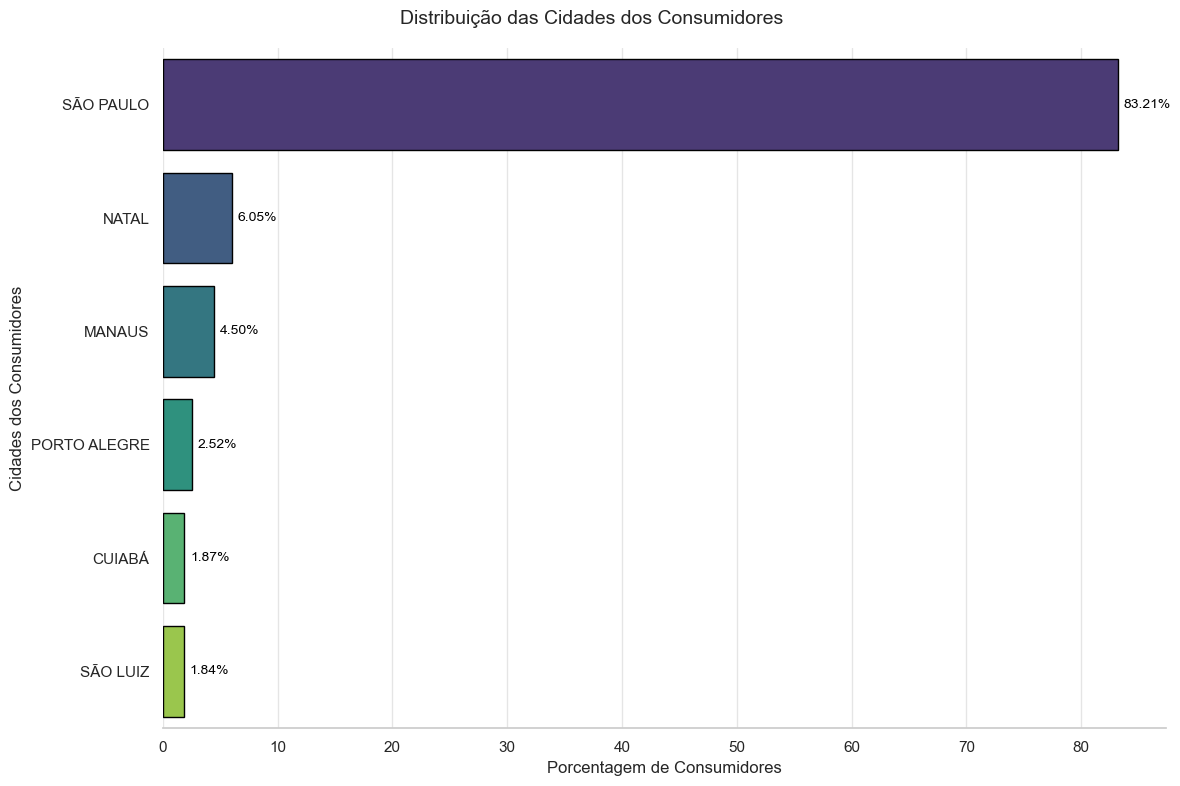

In [237]:
categorias_porcentagens = calcular_porcentagens(df_clientes, 'CIDADE')
plotar_cidades_porcentagem(categorias_porcentagens)

* 83% dos usuários da base estão localizados na cidade de São Paulo/SP, seguido por Natal/RN (6%), Manaus/AM (4%) e Porto Alegre (2%).
* Concentração em São Paulo muito forte, o que pode representar uma operação regionalizada e desproporcional com outras regiões, enquanto as outras três cidades podem ter oportunidade de expansão e crescimento de consumidores.

##### Quais as lojas representam mais transações financeiras (quantidade e valor) da base?

In [238]:
def listar_lojas_com_mais_transacoes(df, coluna_loja, coluna_valor, top_n=30):
    transacoes_por_loja = df.groupby(coluna_loja)[coluna_valor].count().sort_values(ascending=False).head(top_n)
    
    soma_por_loja = df.groupby(coluna_loja)[coluna_valor].sum()
    
    total_transacoes = df[coluna_valor].count()
    total_soma = df[coluna_valor].sum()
    
    porcentagem = (transacoes_por_loja / total_transacoes) * 100
    representatividade_soma = (soma_por_loja.loc[transacoes_por_loja.index] / total_soma) * 100
    
    ticket_medio = (soma_por_loja.loc[transacoes_por_loja.index] / transacoes_por_loja)

    resultado = pd.DataFrame({
        'Transações': transacoes_por_loja,
        'Porcentagem das Transações': porcentagem,
        'Soma das Transações': soma_por_loja.loc[transacoes_por_loja.index],
        'Representatividade da Soma': representatividade_soma,
        'Ticket Médio': ticket_medio
    })

    resultado = resultado.sort_values(by='Representatividade da Soma', ascending=False)
    
    return resultado

In [239]:
lojas_com_mais_transacoes = listar_lojas_com_mais_transacoes(df_financial_transactions, 'NUM_LOJA', 'VALOR')

lojas_com_mais_transacoes.head(10)

,Transações,Porcentagem das Transações,Soma das Transações,Representatividade da Soma,Ticket Médio
NUM_LOJA,,,,,
11,60571,17.161403,4123780.274,18.178641,68.081760
17,44591,12.633837,2758318.422,12.159348,61.858187
19,40463,11.464263,2754106.476,12.140781,68.064812
18,43415,12.300644,2703242.940,11.916562,62.265183
14,32920,9.327127,2136088.954,9.416407,64.887271
21,23261,6.590471,1632482.234,7.196385,70.181086
20,19260,5.456879,1340997.376,5.911447,69.626032
420,22302,6.318760,1259208.906,5.550904,56.461703
410,16481,4.669513,1100432.292,4.850977,66.769753


* As lojas 11, 17 e 19 são as as que detém de maiores quantidade de transações, e esse padrão também é visto na representatividade financeira.
* Há correlação positiva entre número de transações e volume financeiro, ou seja, quem mais vende, também é quem tende a movimentar mais dinheiro, mas esse padrão não tem a mesma correlação quando olhamos Ticket Médio.

##### Como funciona a sazonalidade de valores de transação com o passar dos meses? Ela aumenta ou diminui?

In [240]:
def plotar_transacoes_por_mes_ano(df, coluna_data, coluna_transacoes):
    df['Ano_Mes'] = df[coluna_data].dt.to_period('M')
    
    transacoes_por_mes_ano = df.groupby('Ano_Mes')[coluna_transacoes].sum()

    plt.figure(figsize=(10, 6))
    ax = transacoes_por_mes_ano.plot(kind='bar', color='skyblue')
    plt.title('Transações por Mês/Ano')
    plt.xlabel('Mês/Ano')
    plt.ylabel('Valor Total das Transações')

    ax.ticklabel_format(style='plain', axis='y')
    ax.set_yticks(range(0, int(transacoes_por_mes_ano.max()) + 1, int(transacoes_por_mes_ano.max() // 10)))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

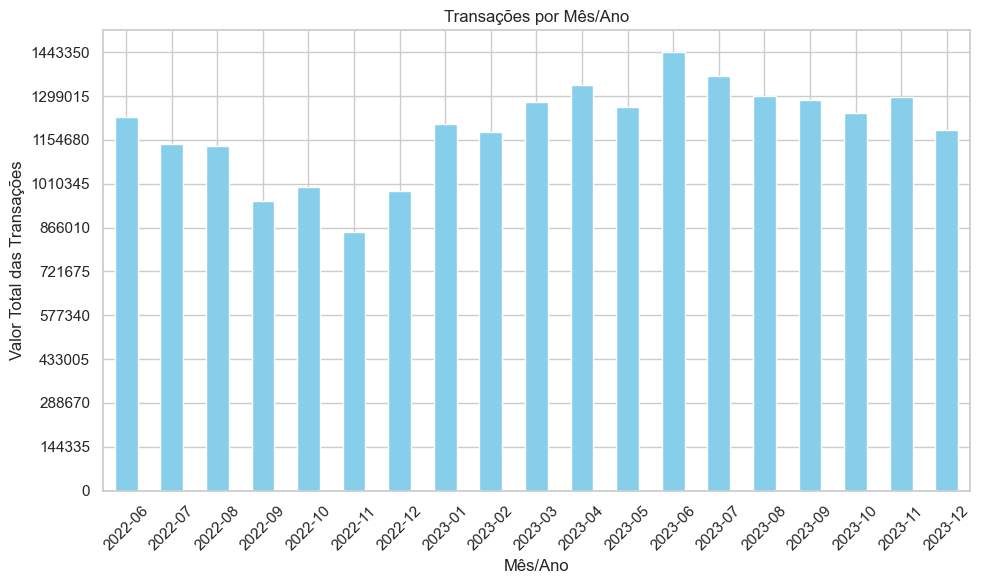

In [241]:
df_financial_transactions['DATA'] = pd.to_datetime(df_financial_transactions['DATA'])

plotar_transacoes_por_mes_ano(df_financial_transactions, 'DATA', 'VALOR')

* Há uma tendência de crescimento entre janeiro/23 a julho/23, com destaque para Julho/23 como o mês com maior movimentação de valores.
* Após fevereiro de 2023, oscilações mensais ocorrem, mas dentro de um intervalo mais estável em 2023..
* 2022 representa um menor valor de transições, em uma tendência de queda nos últimos meses do ano, sendo o pior mês visto nos dados de Novembro/22, período de Black Friday normalmente.

##### Como estão distribuidos os valores de transação?

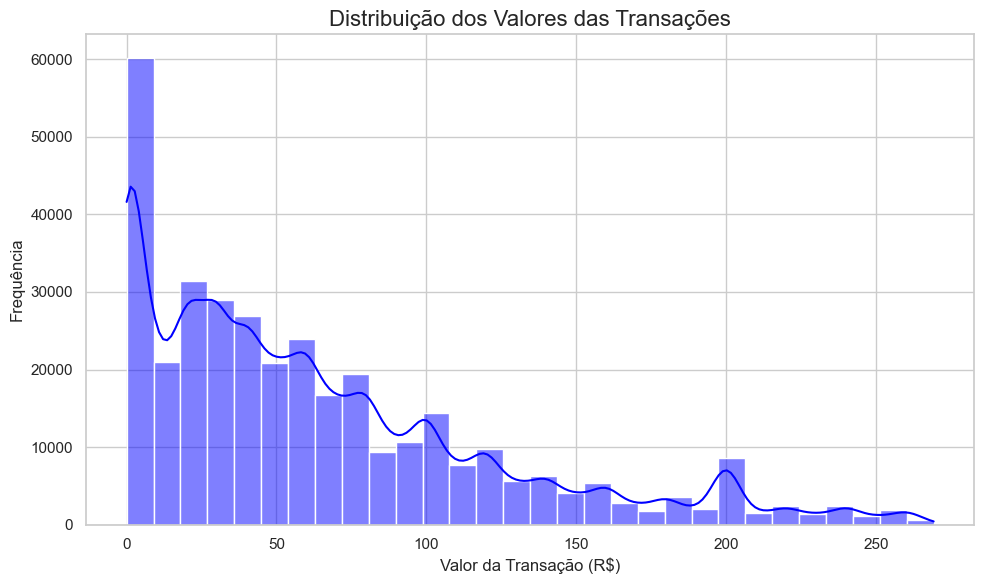

In [242]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data=df_financial_transactions, 
             x='VALOR', 
             bins=30,
             kde=True,
             color='blue')


plt.title('Distribuição dos Valores das Transações', fontsize=16)
plt.xlabel('Valor da Transação (R$)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

plt.tight_layout()
plt.show()


* A distribuição assimetrica positiva a direita que o público é mais ativo em transações de baixo valor.
* Cauda longa: Ainda há valores mais elevados na base, mas sua frequência diminui rapidamente após 100 reais.
* Existem pequenos picos em valores como 100 e 200 reais, o que pode nos informar que há uma adesão a pagamentos de produtos nesses valores, sendo incluso até produtos populares.

#### Principais Insights das Transações Financeiras

##### Distribuição das Transações
- 75% das transações são inferiores a **R$ 93,80**, indicando baixo valor agregado na maioria dos casos.
- A distribuição é **assimétrica à direita**, com **valores altos menos frequentes**, mas ainda presentes.

##### Geografia dos Usuários
- **83% dos usuários estão em São Paulo/SP**, mostrando forte **concentração regional**.
- Outras cidades como **Natal, Manaus e Porto Alegre** apresentam **potencial de expansão**.

##### Lojas com Maior Atividade
- Lojas **11, 17 e 19** lideram em volume de transações e valor movimentado.
- **Ticket médio não acompanha diretamente o volume**, sugerindo **diferenças no perfil de consumo** por loja.

##### Padrão Sazonal
- Crescimento consistente de **março a julho de 2023**, com pico em **julho**.
- **Queda nos valores em jan/fev de 2023**, possivelmente por **efeito pós Black Friday e Natal**.

##### Padrão de Comportamento
- Comportamento de **cauda longa**, com predominância de transações pequenas e algumas grandes.
- **Picos em valores padronizados (R$ 100, R$ 200)** indicam preferência por faixas específicas de preço.

### Criando a clusterização baseada em RFV (Recência, Frequência e Valor)

#### Glossário dos termos utilizados:

* Clusterização RFV: é uma ferramenta usada para realizar a segmentação de clientes, visando entender qual é o comportamento de compra de seus clientes. Através da classificação, é possível identificar quem são os clientes considerados mais valiosos àquele negócio e aqueles que fizeram suas últimas compras recentemente. Por meio da análise desses três pilares, as empresas podem criar perfis detalhados de seus clientes e identificar padrões de comportamento.

* Recência: Quantidade de dias desde a última transação (hoje - último dia).
* Frequência: Número de transações (quantidade).
* Valor: Soma do valor das transações

#### Funções

In [243]:
def prepare_data(df):
    df['DATA'] = pd.to_datetime(df['DATA'])
    data_referencia = df['DATA'].max()

    recencia = (
        df.groupby(['ID_PESSOA', 'PRODUTO'])['DATA']
        .max()
        .reset_index()
    )
    recencia['Recencia'] = (data_referencia - recencia['DATA']).dt.days

    frequencia = (
        df.groupby(['ID_PESSOA', 'PRODUTO'])['DATA']
        .count()
        .reset_index()
    )
    frequencia.columns = ['ID_PESSOA', 'PRODUTO', 'Frequencia']

    valor = (
        df.groupby(['ID_PESSOA', 'PRODUTO'])['VALOR']
        .sum()
        .reset_index()
    )
    valor.columns = ['ID_PESSOA', 'PRODUTO', 'Valor']

    rfv = (
        recencia[['ID_PESSOA', 'PRODUTO', 'Recencia']]
        .merge(frequencia, on=['ID_PESSOA', 'PRODUTO'])
        .merge(valor, on=['ID_PESSOA', 'PRODUTO'])
    )

    return rfv

In [244]:
def scale_data(df):
    
    scaler = MinMaxScaler()
    df[['Recencia', 'Frequencia', 'Valor']] = scaler.fit_transform(
        df[['Recencia', 'Frequencia', 'Valor']]
    )
    return df

In [245]:
def cluster_analysis(df, amostra_percentual=0.2, minimo_clusters=2, maximo_clusters=11):
    amostra_rfv = df.sample(frac=amostra_percentual, random_state=42)

    silhouette_scores = []
    range_n_clusters = range(minimo_clusters, maximo_clusters)

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(amostra_rfv[['Recencia', 'Frequencia', 'Valor']])
        score = silhouette_score(amostra_rfv[['Recencia', 'Frequencia', 'Valor']], cluster_labels)
        silhouette_scores.append(score)

    
    plt.figure(figsize=(8, 5))
    plt.plot(range_n_clusters, silhouette_scores, marker='o')
    plt.xticks(range_n_clusters)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Escolha do Número de Clusters com Silhouette Score (Amostra de 20%)')
    plt.grid()
    plt.show()

    return silhouette_scores

#### Definindo a Sulhuette Score

In [246]:
rfv = prepare_data(df_financial_transactions)

In [247]:
rfv_scaled = scale_data(rfv)

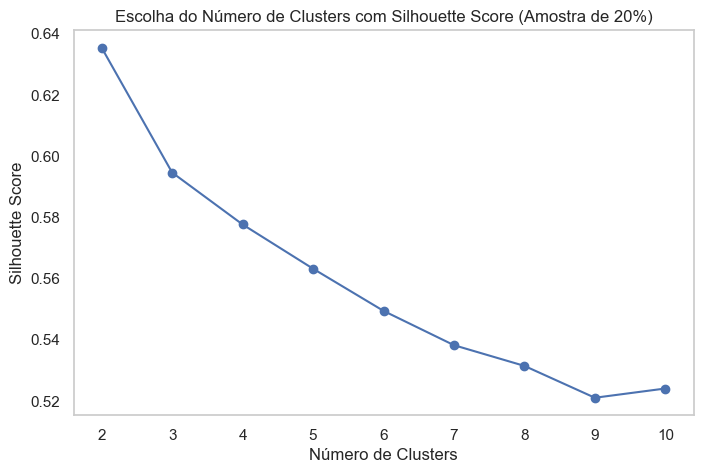

In [248]:
silhouette_scores = cluster_analysis(rfv_scaled)

### Aplicando a clusterização com base nos produtos

#### Funções

In [249]:
def calcular_rfv_segmentacao_com_silhouette(df_produto, n_clusters=4, amostra_percentual=0.2, tipo_produto='pre_pago'):
    mapeamentos = {
        'pre_pago': {
            0: "Campeões", 
            1: "Pontuais",
            2: "Desengajados",
            3: "Econômicos"
        },
        'recarga_digital': {
            0: "Desacelerados",
            1: "Estrelas",
            2: "Abandonadores",
            3: "Entusiastas"
        }
    }

    # Preparação dos dados
    df_produto['DATA'] = pd.to_datetime(df_produto['DATA'])
    data_referencia = df_produto['DATA'].max()

    recencia = df_produto.groupby('ID_PESSOA')['DATA'].max().reset_index()
    recencia['Recencia'] = (data_referencia - recencia['DATA']).dt.days

    frequencia = df_produto.groupby('ID_PESSOA')['DATA'].count().reset_index()
    frequencia.columns = ['ID_PESSOA', 'Frequencia']

    valor = df_produto.groupby('ID_PESSOA')['VALOR'].sum().reset_index()
    valor.columns = ['ID_PESSOA', 'Valor']

    rfv_produto = recencia[['ID_PESSOA', 'Recencia']] \
        .merge(frequencia, on='ID_PESSOA') \
        .merge(valor, on='ID_PESSOA')

    # Armazenar valores originais antes da normalização
    rfv_produto['RecenciaOriginal'] = rfv_produto['Recencia']
    rfv_produto['FrequenciaOriginal'] = rfv_produto['Frequencia']
    rfv_produto['ValorOriginal'] = rfv_produto['Valor']

    # Normalização
    scaler = MinMaxScaler()
    rfv_produto[['Recencia', 'Frequencia', 'Valor']] = scaler.fit_transform(
        rfv_produto[['Recencia', 'Frequencia', 'Valor']]
    )

    # Amostragem
    if amostra_percentual < 1.0:
        rfv_produto = rfv_produto.sample(frac=amostra_percentual, random_state=42)

    # Clusterização
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    rfv_produto['Cluster'] = kmeans.fit_predict(rfv_produto[['Recencia', 'Frequencia']])
    silhouette_avg = silhouette_score(rfv_produto[['Recencia', 'Frequencia']], rfv_produto['Cluster'])

    print(f"Silhouette Score para {df_produto['PRODUTO'].iloc[0]}: {silhouette_avg:.2f}")

    # Mapear nome dos clusters
    mapeamento_escolhido = mapeamentos.get(tipo_produto, {})
    rfv_produto['NomeCluster'] = rfv_produto['Cluster'].map(mapeamento_escolhido)

    # Reverter escalonamento para plotar centróides
    scaler_rf = MinMaxScaler()
    scaler_rf.fit(rfv_produto[['RecenciaOriginal', 'FrequenciaOriginal']])
    centroids_original = scaler_rf.inverse_transform(kmeans.cluster_centers_)

    # Plot: Dispersão
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rfv_produto,
        x='RecenciaOriginal',
        y='FrequenciaOriginal',
        hue='NomeCluster',
        palette='tab10',
        s=60,
        edgecolor='black',
        alpha=0.7
    )

    for x, y in centroids_original:
        plt.scatter(x, y, c='black', s=200, marker='X', label='_nolegend_')

    plt.title(f'Perfis de Clientes - {df_produto["PRODUTO"].iloc[0]}', fontsize=16, pad=15)
    plt.xlabel('Quanto tempo faz desde a última compra? (dias)', fontsize=12)
    plt.ylabel('Com que frequência esse cliente compra?', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
    plt.legend(title="Perfis de Clientes")
    plt.tight_layout()
    plt.show()

    # Resumo dos clusters
    resumo_clusters = (
    rfv_produto.groupby('NomeCluster')[['RecenciaOriginal', 'FrequenciaOriginal', 'ValorOriginal']]
    .mean()
    .round(1)
    .reset_index()
)

    resumo_clusters.columns = ['Perfil', 'Média Recência (dias)', 'Média Frequência', 'Média Valor (R$)']
    
    print("\nResumo dos clusters:")
    print(resumo_clusters.to_string(index=False))

    return rfv_produto, silhouette_avg, kmeans, scaler

In [250]:
df_produto_vale = df_financial_transactions[df_financial_transactions['PRODUTO'] == 'PRODUTO VALE']
df_produto_digital = df_financial_transactions[df_financial_transactions['PRODUTO'] == 'PRODUTO DIGITAL']

#### Criando a visualização e exportando para Excel - PRODUTO VALE

Silhouette Score para PRODUTO VALE: 0.58


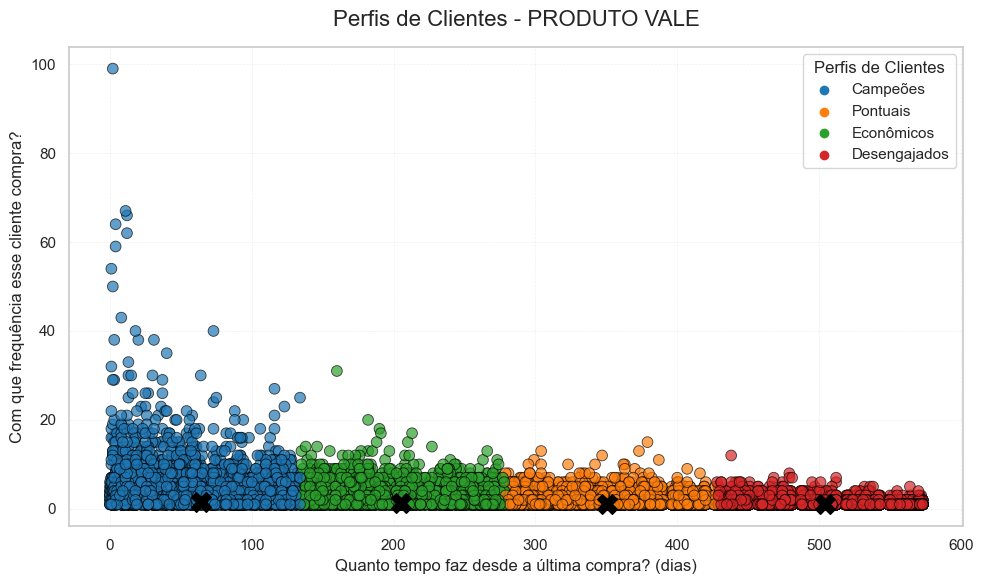


Resumo dos clusters:
      Perfil  Média Recência (dias)  Média Frequência  Média Valor (R$)
    Campeões                   64.0               3.9             219.9
Desengajados                  504.2               1.4              71.6
  Econômicos                  206.0               2.5             132.7
    Pontuais                  351.1               1.8              96.7


In [251]:
rfv_pre_pago, sil_pre, km_pre, scaler_pre = calcular_rfv_segmentacao_com_silhouette(
    df_produto_vale, tipo_produto='pre_pago'
)

Silhouette Score para PRODUTO DIGITAL: 0.57


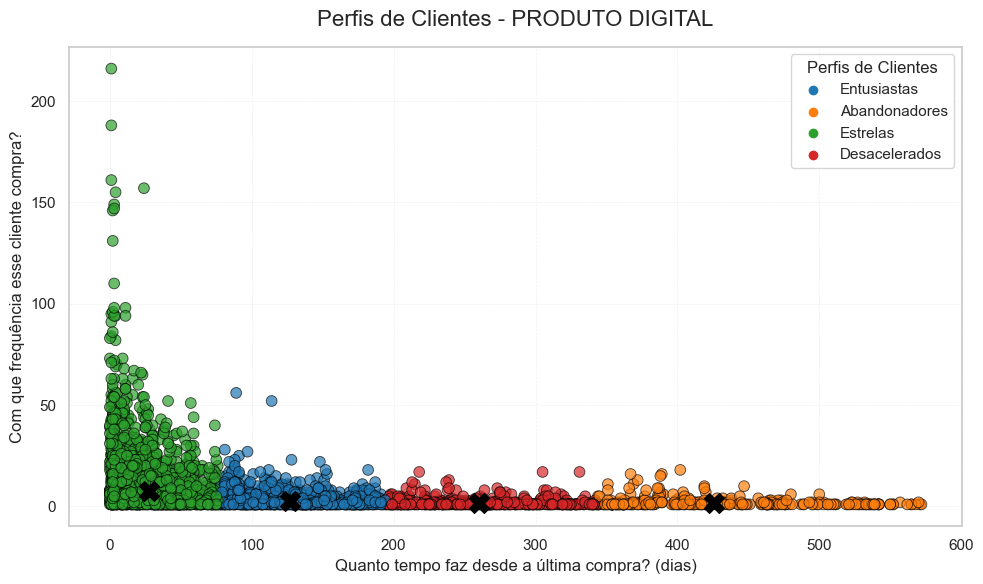


Resumo dos clusters:
       Perfil  Média Recência (dias)  Média Frequência  Média Valor (R$)
Abandonadores                  426.7               2.1             162.5
Desacelerados                  261.3               2.0             192.5
  Entusiastas                  127.5               3.9             338.9
     Estrelas                   27.7              13.5            1061.3


In [252]:
rfv_digital, sil_digital, km_digital, scaler_dig = calcular_rfv_segmentacao_com_silhouette(
    df_produto_digital, tipo_produto='recarga_digital'
)

#### Exportar para Excel os usuários

In [72]:
mapeamento_clusters_produto_vale  = {
    0: "Campeões", 
    1: "Pontuais",
    2: "Desengajados",
    3: "Econômicos"
}

mapeamento_clusters_recarga_digital  = {
    0: "Desacelerados",
    1: "Estrelas",
    2: "Abandonadores",
    3: "Entusiastas"
}

In [73]:
def exportar_clusters_para_excel(df_usuarios: pd.DataFrame, mapeamento_clusters: dict, nome_arquivo: str, pasta_destino: str = r'..\output'):
    
    os.makedirs(pasta_destino, exist_ok=True)

    df_filtrado = df_usuarios[
        df_usuarios['ID_PESSOA'].notna() &
        df_usuarios['Cluster'].notna()
    ].copy()

    df_filtrado['Nome_Cluster'] = df_filtrado['Cluster'].map(mapeamento_clusters)

    df_filtrado = df_filtrado.drop_duplicates(subset=['ID_PESSOA', 'Cluster'])

    resumo_df = (
        df_filtrado.groupby(['Cluster', 'Nome_Cluster'])
        .size()
        .reset_index(name='Quantidade de Usuários')
    )

    caminho_completo = os.path.join(pasta_destino, nome_arquivo)

    with pd.ExcelWriter(caminho_completo, engine='openpyxl') as writer:
        df_filtrado.to_excel(writer, sheet_name='Usuarios por Cluster', index=False)
        resumo_df.to_excel(writer, sheet_name='Resumo', index=False)

    print(f"✅ Arquivo salvo com sucesso em: {caminho_completo}")

#### Produto Pré Pago

In [74]:
df_produto_vale['DATA'] = pd.to_datetime(df_produto_vale['DATA'])
data_referencia = df_produto_vale['DATA'].max()

recencia_full = df_produto_vale.groupby('ID_PESSOA')['DATA'].max().reset_index()
recencia_full['Recencia'] = (data_referencia - recencia_full['DATA']).dt.days

frequencia_full = df_produto_vale.groupby('ID_PESSOA')['DATA'].count().reset_index()
frequencia_full.columns = ['ID_PESSOA', 'Frequencia']

valor_full = df_produto_vale.groupby('ID_PESSOA')['VALOR'].sum().reset_index()
valor_full.columns = ['ID_PESSOA', 'Valor']

rfv_vale_full = recencia_full.merge(frequencia_full, on='ID_PESSOA').merge(valor_full, on='ID_PESSOA')

In [75]:
rfv_vale_full[['Recencia', 'Frequencia', 'Valor']] = scaler_pre.transform(
    rfv_vale_full[['Recencia', 'Frequencia', 'Valor']]
)

rfv_vale_full['Cluster'] = km_pre.predict(rfv_vale_full[['Recencia', 'Frequencia']])


In [76]:
usuarios_por_cluster_df_pre = rfv_vale_full[['ID_PESSOA', 'Cluster']].drop_duplicates()

print(f"🔎 Total de IDs únicos com cluster: {usuarios_por_cluster_df_pre.shape[0]}")

exportar_clusters_para_excel(
    df_usuarios=usuarios_por_cluster_df_pre,
    mapeamento_clusters=mapeamento_clusters_produto_vale,
    nome_arquivo="usuarios_por_cluster_produto_vale.xlsx"
)

🔎 Total de IDs únicos com cluster: 87138
✅ Arquivo salvo com sucesso em: ..\output\usuarios_por_cluster_produto_vale.xlsx


#### Produto Digital

In [77]:
df_produto_digital['DATA'] = pd.to_datetime(df_produto_digital['DATA'])
data_referencia = df_produto_digital['DATA'].max()

recencia_full = df_produto_digital.groupby('ID_PESSOA')['DATA'].max().reset_index()
recencia_full['Recencia'] = (data_referencia - recencia_full['DATA']).dt.days

frequencia_full = df_produto_digital.groupby('ID_PESSOA')['DATA'].count().reset_index()
frequencia_full.columns = ['ID_PESSOA', 'Frequencia']

valor_full = df_produto_digital.groupby('ID_PESSOA')['VALOR'].sum().reset_index()
valor_full.columns = ['ID_PESSOA', 'Valor']

rfv_digital_full = recencia_full.merge(frequencia_full, on='ID_PESSOA').merge(valor_full, on='ID_PESSOA')

rfv_digital_full[['Recencia', 'Frequencia', 'Valor']] = scaler_dig.transform(
    rfv_digital_full[['Recencia', 'Frequencia', 'Valor']]
)

rfv_digital_full['Cluster'] = km_digital.predict(rfv_digital_full[['Recencia', 'Frequencia']])

usuarios_por_cluster_df_digital = rfv_digital_full[['ID_PESSOA', 'Cluster']].drop_duplicates()

print(f"🔎 Total de IDs únicos com cluster: {usuarios_por_cluster_df_digital.shape[0]}")

exportar_clusters_para_excel(
    df_usuarios=usuarios_por_cluster_df_digital,
    mapeamento_clusters=mapeamento_clusters_recarga_digital,
    nome_arquivo="usuarios_por_cluster_produto_digital.xlsx"
)

🔎 Total de IDs únicos com cluster: 15559
✅ Arquivo salvo com sucesso em: ..\output\usuarios_por_cluster_produto_digital.xlsx
